In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt
import pandas as pd

tf.get_logger().setLevel('ERROR')


c:\Users\victo\anaconda3\envs\aops_tf\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\victo\anaconda3\envs\aops_tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
I

# Prepare & Load Dataset

In [2]:
# import nltk
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
class GeneralNLPPreprocessing:
    
    def remove_punctuation(self, text):
        # import string

        punctuations = string.punctuation  # !\"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~
        no_punct = "".join([char for char in text if char not in punctuations])
        return no_punct

    def remove_stopwords(self, text):
        # import nltk
        # from nltk.corpus import stopwords
        # nltk.download('stopwords')

        stop_words = stopwords.words('english')  # Get English stopwords
        words = text.split()  # Convert text to lowercase and split into words
        filtered_words = [word for word in words if word.lower() not in stop_words]  # Filter out stop words
        return " ".join(filtered_words)

    def lowercase(self, text):
        return text.lower()

    def stemming(self, text):
        # import nltk
        # from nltk.stem import PorterStemmer
        # nltk.download('punkt')

        stemmer = PorterStemmer()
        words = text.split()
        stemmed_words = [stemmer.stem(word, to_lowercase=False) for word in words]  # Apply stemming to each word
        return " ".join(stemmed_words)

    def lemmatize(self, text):
        import nltk
        from nltk.stem import WordNetLemmatizer
        from nltk.corpus import wordnet

        def get_wordnet_pos(treebank_tag):
            """
            Convert the part-of-speech naming scheme from Penn Treebank to WordNet.
            """
            if treebank_tag.startswith('J'):
                return wordnet.ADJ
            elif treebank_tag.startswith('V'):
                return wordnet.VERB
            elif treebank_tag.startswith('N'):
                return wordnet.NOUN
            elif treebank_tag.startswith('R'):
                return wordnet.ADV
            else:
                return wordnet.NOUN  # Default to noun if not found
        """
        Perform lemmatization on the input text.
        """
        lemmatizer = WordNetLemmatizer()
        tokens = nltk.word_tokenize(text)
        pos_tags = nltk.pos_tag(tokens)
        lemmatized_words = []
        for word, tag in pos_tags:
            pos = get_wordnet_pos(tag)
            lemmatized_word = lemmatizer.lemmatize(word, pos=pos)
            lemmatized_words.append(lemmatized_word)
        return ' '.join(lemmatized_words)

    def fit(self, text):
        # text = self.remove_punctuation(text)
        text = self.remove_stopwords(text)
        # text = self.lowercase(text)
        text = self.stemming(text)
        # text = self.lemmatize(text)

        return text


import re
import html
import unicodedata
from bs4 import BeautifulSoup
class Preprocess:

    def decode_html_entities(self, text: str):
        """
        Decode HTML entities in a given text. Example:
            - &amp; --> &
            - &lt; --> <
            - &gt; --> >
            - &quot; --> "
            - &apos; --> '
            - etc.
        """
        # import html

        decoded_text = html.unescape(text)
        return str(decoded_text)

    def remove_html_tag_in_a_text(self, text: str):
        """
        Remove html tag in a text such as:
            - <br>
            - <span></span>
            - <b></b>
            - etc.
        """
        # from bs4 import BeautifulSoup

        clean_text = BeautifulSoup(text, 'html.parser').get_text()
        return str(clean_text)

    def remove_accented_characters(self, text: str):
        """
        Function replaces accented characters with their closest ASCII equivalents.
        In some cases, this may not be the desired behavior.
        For example, the character "ñ" would be replaced with "n".

        ÀáÉéÍíÓóÚúÑñ --> AaEeIiOoUuNn
        """
        # import unicodedata

        new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        return str(new_text)

    def remove_redundant_white_spaces(self, text: str):
        # import re

        clean_text = re.sub(r'\s+', ' ', text).strip()
        return str(clean_text)

    def replace_img_tag_with_the_alt_attribute(self, html_text: str):
        """
        Before using this function, must perform:
            - `decode_html_entities()`
        """
        # from bs4 import BeautifulSoup

        soup = BeautifulSoup(html_text, 'html.parser')
        img_tags = soup.find_all('img')

        # Replace img tags with their alt attribute content
        for img_tag in img_tags:
            alt_text = img_tag.get('alt', '[MISSING_ALT]')  # Get alt attribute or [MISSING_ALT] string if missing
            img_tag.replace_with(alt_text)

        modified_text = str(soup)

        return modified_text

    def clean_text(self, text: str):
        text = text.replace("\n", " ")
        text = text.replace("\t", " ")
        text = text.replace("\r", " ")
        text = text.replace("\v", " ")
        return text

    def findall_occurrences_of_LaTex(self, text: str) -> list:
        """
        Find/capture all occurrences LaTex that indicated with `$ ... $` with an n number of `$`
        """
        # import re

        regex = re.compile(r'(\$+.*?\$+)')
        matches = re.findall(regex, text)  # Output: [$...$, $...$, ...]

        return matches

    def extract_inside_dollar_sign(self, text: str) -> str:
        """
        This function only for this specific input:
            - `$ 1/x \leq 10 $`  -->  ` 1/x \leq 10 `
            - `$1  anything z$`  -->  `1   anything z`  with the redundant spaces

        You can say this function remove suffix and prefix for `$` sign\n
        OR\n
        It takes/extracts text that flanked (diapit) with `$` sign
        """
        # import re

        regex = re.compile(r'\$+(.*?)\$+')
        result = re.findall(regex, text)
        return result[0]

    def fit(self, text: str):
        # text = self.remove_redundant_white_spaces(text)
        text = self.decode_html_entities(text)
        # text = self.remove_redundant_white_spaces(text)
        text = self.remove_accented_characters(text)
        # text = self.remove_redundant_white_spaces(text)
        text = self.clean_text(text)
        text = self.remove_redundant_white_spaces(text)
        text = self.replace_img_tag_with_the_alt_attribute(text)

        # text = self.remove_redundant_white_spaces(text)
        text = self.remove_html_tag_in_a_text(text)
        text = self.remove_redundant_white_spaces(text)

        text = text.replace("\[", "$")
        text = text.replace("\]", "$")

        captured_LaTex = self.findall_occurrences_of_LaTex(text)
        processed_LaTex = captured_LaTex.copy()
        for i in range(len(processed_LaTex)):
            processed_LaTex[i] = self.extract_inside_dollar_sign(processed_LaTex[i])

        for j in range(len(captured_LaTex)):
            text = text.replace(captured_LaTex[j], processed_LaTex[j])

        # text = GeneralNLPPreprocessing().fit(text)
        text = text.replace("\\", " ")
        text = self.remove_redundant_white_spaces(text)
        return text


In [3]:
from sklearn.model_selection import train_test_split

AUTOTUNE = tf.data.AUTOTUNE  # Output: -1 --> <class 'int'>
batch_size = 8
seed = 42
def load_and_prepare_dataset() -> tuple[tf.data.Dataset]:
    
    df = pd.read_csv("imo_combined.csv")

    df['post_canonical'] = df['post_rendered'].apply(Preprocess().fit)
    df = df[['post_canonical', 'score']]

    train, test = train_test_split(df, test_size=0.2, random_state=42)    # train: 340 - test: 85
    train, val = train_test_split(train, test_size=0.1, random_state=42)  # train: 306 - val:  34
    
    train_post_canonical = train['post_canonical'].values
    train_score = train['score'].values
    
    val_post_canonical = val['post_canonical'].values
    val_score = val['score'].values
    
    test_post_canonical = test['post_canonical'].values
    test_score = test['score'].values
    
    train_ds = tf.data.Dataset.from_tensor_slices((train_post_canonical, train_score))
    val_ds = tf.data.Dataset.from_tensor_slices((val_post_canonical, val_score))
    test_ds = tf.data.Dataset.from_tensor_slices((test_post_canonical, test_score))


    train_ds = train_ds.shuffle(buffer_size=len(train), seed=seed).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = load_and_prepare_dataset()


C:\Users\victo\AppData\Local\Temp\ipykernel_11404\3053953799.py:116: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  clean_text = BeautifulSoup(text, 'html.parser').get_text()


# Model

In [4]:
for text_batch, score_batch in train_ds.take(3):
    for i in range(2):
        text = text_batch.numpy()[i].decode('utf-8')  # Decode bytes to string
        label = score_batch.numpy()[i]
        print(f'Text: {text}')
        print(f'Score: {label}')
    print("================================================\n")

Text: We have 0 le x_i<b for i=0,1, ldots,n and x_n>0,x_{n-1}>0. If a>b, and x_nx_{n-1} ldots x_0 represents the number A base a and B base b, whilst x_{n-1}x_{n-2} ldots x_0 represents the number A' base a and B' base b, prove that A'B<AB'.
Score: 1.5102040816326523
Text: Prove that cos{ frac{ pi}{7}}- cos{ frac{2 pi}{7}}+ cos{ frac{3 pi}{7}}= frac{1}{2}
Score: 6.041666666666668

Text: Let D be an interior point of the acute triangle ABC with AB > AC so that angle DAB = angle CAD. The point E on the segment AC satisfies angle ADE = angle BCD, the point F on the segment AB satisfies angle FDA = angle DBC, and the point X on the line AC satisfies CX = BX. Let O_1 and O_2 be the circumcenters of the triangles ADC and EXD, respectively. Prove that the lines BC, EF, and O_1O_2 are concurrent.
Score: 9.469189937687512
Text: Triangle ABC has circumcircle Omega and circumcenter O. A circle Gamma with center A intersects the segment BC at points D and E, such that B, D, E, and C are all differ

In [9]:
# bert_model_name = ""
# tfhub_handle_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/2"
tfhub_handle_encoder = "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-cased-l-12-h-768-a-12/versions/4"
tfhub_handle_preprocess = "https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-cased-preprocess/versions/3"
# preprocessor = hub.load(tfhub_handle_preprocess)


bert_model = hub.KerasLayer(tfhub_handle_encoder)
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')


BERT model selected           : https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-cased-l-12-h-768-a-12/versions/4
Preprocess model auto-selected: https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-cased-preprocess/versions/3


In [6]:
text_test = ['A social network has 2019 users, some pairs of whom are friends. Whenever user A is friends with user B, user B is also friends with user A. Events of the following kind may happen repeatedly, one at a time: Three users A, B, and C such that A is friends with both B and C, but B and C are not friends, change their friendship statuses such that B and C are now friends, but A is no longer friends with B, and no longer friends with C. All other friendship statuses are unchanged. Initially, 1010 users have 1009 friends each, and 1009 users have 1010 friends each. Prove that there exists a sequence of such events after which each user is friends with at most one other user. Proposed by Adrian Beker, Croatia']
# text_test = ['x^2']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :10]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :10]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :10]}')


ValueError: Exception encountered when calling layer "keras_layer_1" "                 f"(type KerasLayer).

Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (3 total):
    * ['A social network has 2019 users, some pairs of whom are friends. Whenever '
 'user A is friends with user B, user B is also friends with user A. Events of '
 'the following kind may happen repeatedly, one at a time: Three users A, B, '
 'and C such that A is friends with both B and C, but B and C are not friends, '
 'change their friendship statuses such that B and C are now friends, but A is '
 'no longer friends with B, and no longer friends with C. All other friendship '
 'statuses are unchanged. Initially, 1010 users have 1009 friends each, and '
 '1009 users have 1010 friends each. Prove that there exists a sequence of '
 'such events after which each user is friends with at most one other user. '
 'Proposed by Adrian Beker, Croatia']
    * False
    * None
  Keyword arguments: {'max_length': 512}

 Expected these arguments to match one of the following 4 option(s):

Option 1:
  Positional arguments (3 total):
    * TensorSpec(shape=(None,), dtype=tf.string, name='sentences')
    * False
    * None
  Keyword arguments: {}

Option 2:
  Positional arguments (3 total):
    * TensorSpec(shape=(None,), dtype=tf.string, name='sentences')
    * True
    * None
  Keyword arguments: {}

Option 3:
  Positional arguments (3 total):
    * TensorSpec(shape=(None,), dtype=tf.string, name='inputs')
    * False
    * None
  Keyword arguments: {}

Option 4:
  Positional arguments (3 total):
    * TensorSpec(shape=(None,), dtype=tf.string, name='inputs')
    * True
    * None
  Keyword arguments: {}

Call arguments received by layer "keras_layer_1" "                 f"(type KerasLayer):
  • inputs=["'A social network has 2019 users, some pairs of whom are friends. Whenever user A is friends with user B, user B is also friends with user A. Events of the following kind may happen repeatedly, one at a time: Three users A, B, and C such that A is friends with both B and C, but B and C are not friends, change their friendship statuses such that B and C are now friends, but A is no longer friends with B, and no longer friends with C. All other friendship statuses are unchanged. Initially, 1010 users have 1009 friends each, and 1009 users have 1010 friends each. Prove that there exists a sequence of such events after which each user is friends with at most one other user. Proposed by Adrian Beker, Croatia'"]
  • training=None

In [7]:
# bert_results = bert_model(text_preprocessed)

# print(f'Loaded BERT: {(tfhub_handle_encoder)}\n')
# print(f'Keys: {list(bert_results.keys())}')
# print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
# print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
# print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
# print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')


In [10]:
def build_regressor_model(tfhub_preprocess, tfhub_encoder):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    
    preprocessing_layer = hub.KerasLayer(tfhub_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    
    encoder = hub.KerasLayer(tfhub_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(256, activation='relu')(net)  # Additional dense layer
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(128, activation='relu')(net)  # Additional dense layer
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation='linear', name='regressor')(net)
    
    return tf.keras.Model(text_input, net)


In [11]:
regressor_model = build_regressor_model(tfhub_preprocess=tfhub_handle_preprocess, tfhub_encoder=tfhub_handle_encoder)

epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
optimizer = optimization.create_optimizer(
    init_lr=1e-4,
    num_train_steps=num_train_steps,
    num_warmup_steps=int(0.1*num_train_steps),
    optimizer_type='adamw')
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

loss = tf.keras.losses.mean_squared_error
metrics = ['mae']

regressor_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)


In [12]:
history = regressor_model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=epochs
    )


Epoch 1/3


35/35 [==============================] - 15s 202ms/step - loss: 12.6567 - mae: 2.7767 - val_loss: 4.0417 - val_mae: 1.7356
Epoch 2/3
35/35 [==============================] - 7s 187ms/step - loss: 5.4602 - mae: 1.9103 - val_loss: 4.9394 - val_mae: 1.8456
Epoch 3/3
35/35 [==============================] - 7s 187ms/step - loss: 5.4798 - mae: 1.8976 - val_loss: 4.4662 - val_mae: 1.8319


Find all real functions $f$ defined on $\mathbb{R}$, such that $f(f(x)+y) = f(f(x)-y)+4f(x)y$ ,for all real numbers $x,y$.

In [13]:
example_text = "Find all real functions f defined on mathbb R, such that f(f(x)+y) = f(f(x)-y)+4f(x)y ,for all real numbers x,y."
regressor_model.predict(tf.constant([example_text]))


1/1 [==============================] - 0s 490ms/step


array([[6.173266]], dtype=float32)

In [14]:
loss, mae = regressor_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'MAE: {mae}')


10/10 [==============================] - 1s 62ms/step - loss: 6.2743 - mae: 2.1155
Loss: 6.2743048667907715
Accuracy: 2.1155002117156982


In [15]:
history.history

{'loss': [12.656743049621582, 5.460222244262695, 5.479800224304199],
 'mae': [2.7767105102539062, 1.910332441329956, 1.8975918292999268],
 'val_loss': [4.041679859161377, 4.939436435699463, 4.4661784172058105],
 'val_mae': [1.735615849494934, 1.845645785331726, 1.8318814039230347]}

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


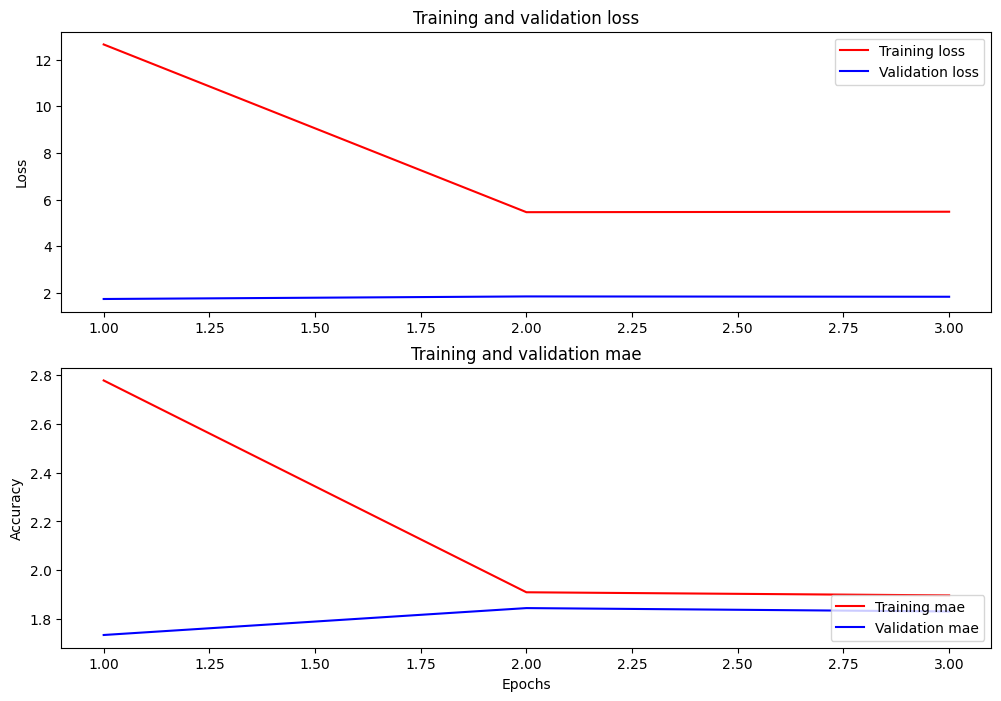

In [16]:
history_dict = history.history
print(history_dict.keys())

mae = history_dict['mae']
val_acc = history_dict['val_mae']
loss = history_dict['loss']
val_mae = history_dict['val_mae']

epochs = range(1, len(mae) + 1)
fig = plt.figure(figsize=(12, 8))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_mae, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, mae, 'r', label='Training mae')
plt.plot(epochs, val_acc, 'b', label='Validation mae')
plt.title('Training and validation mae')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
